In [80]:
import pandas as pd
import numpy as np
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, jaccard_score, hamming_loss, log_loss

from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

import keras
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import Adam, rmsprop
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from get_labeled_dfs import *
from process_text import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
# use custom function to get the corpus df, label dfs, and validation dfs
corpus_df, emotion_df, valence_df = get_labeled_dfs()


In [3]:
# using custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)

In [4]:
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,two hussein ally hang iraqi official say
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


In [5]:
valence_df.head()

,valence,label
0,32,1
1,-48,0
2,26,1
3,40,1
4,-6,2


In [6]:
emotion_df.head()

,anger,disgust,fear,joy,sadness,surprise,max,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,15,38,9,11,joy,0,0,1,1,1,1
1,24,26,16,13,38,5,sadness,1,1,1,1,1,1
2,0,0,0,17,0,4,joy,0,0,0,1,0,1
3,0,0,0,46,0,31,joy,0,0,0,1,0,1
4,1,0,23,8,11,8,fear,1,0,1,1,1,1


## Prepare Multilabel Classification Evaluation

In [11]:
def label_confusion_matrices(lst, df, RNN=False):
    
    '''A function that creates confusion matrices and calculates accuracy, precision, 
    recall, and f1 for each individual label'''
    
    plt.figure(figsize=(15,20))
    subplot_num = 1

    for i in lst:
        
        if RNN==False:
        
            tp = len(df.loc[(df['pred_' + i]==1) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]==1) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]==0) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]==0) & (df[i]==0)])
        
        else:
            
            tp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==0)])
        
        
        plt.subplot(3,2,subplot_num)
        sns.heatmap([[tp, fp], [tn, fn]], square=True, annot=True, fmt='g', yticklabels=[i, 'not ' + i], xticklabels=[i, 'not ' + i])
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(i.capitalize() + ' Confusion Matrix')
        subplot_num+=1
        
        accuracy = tp/(fp + tn + tp)
        precision = tp/(fp + tp)
        recall = tp/(tp + fn)
        f1 = 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn))))
        
        print(i + " accuracy:", accuracy)
        print(i + " precision:", precision)
        print(i + " recall", recall)
        print(i + " f1", 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn)))))
        print('\n')

        

In [12]:
def suite_of_scores(y_true, y_pred):
    
    '''A function that calculates jaccard similarity, hamming loss, f1 macro, 
    and log loss to assess the model's overall performance'''
    
    jaccard_score_samples = jaccard_score(y_true, y_pred, average='samples')
    hamming_loss_score = hamming_loss(y_true, y_pred)
    f1_macro_score = f1_score(y_true, y_pred, average='macro')
    log_loss_score = log_loss(y_true, y_pred)
    
    print('jaccard score average:', round(jaccard_score_samples, 3))
    print('hamming loss:', round(hamming_loss_score, 3))
    print('f1 macro:', round(f1_macro_score, 3))
    print('log loss', round(log_loss_score, 3))

## Baseline: One Versus Rest with SVM

In [26]:
X_train, X_test, y_train, y_test = train_test_split(corpus_df['text'], emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']], random_state=3)


In [27]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_test


<313x2332 sparse matrix of type '<class 'numpy.float64'>'
	with 1138 stored elements in Compressed Sparse Row format>

In [54]:
svc = LinearSVC(class_weight='balanced')

ovr = OneVsRestClassifier(svc)

ovr.fit(tf_idf_X_train, y_train)
ovr_train_preds = ovr.predict(tf_idf_X_train)
ovr_test_preds = ovr.predict(tf_idf_X_test)

In [55]:
ovr_preds_df = pd.DataFrame(ovr_test_preds, columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
ovr_preds_df = pd.concat([ovr_preds_df, y_reindex], axis=1)

anger_label accuracy: 0.49454545454545457
anger_label precision: 0.8143712574850299
anger_label recall 0.7816091954022989
anger_label f1 0.7976539589442815


disgust_label accuracy: 0.33976833976833976
disgust_label precision: 0.676923076923077
disgust_label recall 0.6197183098591549
disgust_label f1 0.6470588235294118


fear_label accuracy: 0.6376811594202898
fear_label precision: 0.8186046511627907
fear_label recall 0.8262910798122066
fear_label f1 0.8224299065420559


joy_label accuracy: 0.5454545454545454
joy_label precision: 0.75
joy_label recall 0.7461139896373057
joy_label f1 0.7480519480519481


sadness_label accuracy: 0.6785714285714286
sadness_label precision: 0.8189655172413793
sadness_label recall 0.852017937219731
sadness_label f1 0.8351648351648352


surprise_label accuracy: 0.8885017421602788
surprise_label precision: 0.9205776173285198
surprise_label recall 0.9074733096085409
surprise_label f1 0.9139784946236559




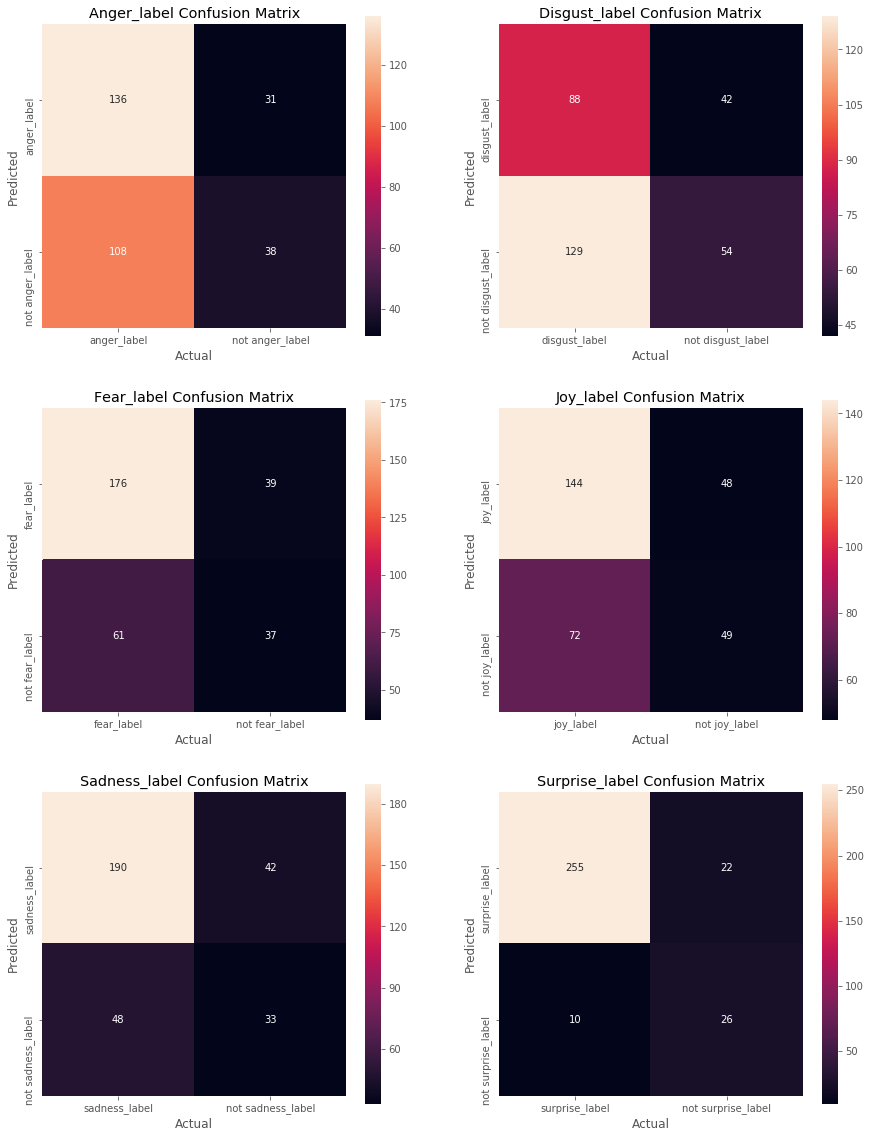

In [56]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], ovr_preds_df)


In [57]:
jaccard_score_samples = jaccard_score(y_test, ovr_test_preds, average='samples')
jaccard_score_weighted = jaccard_score(y_test, ovr_test_preds, average='weighted')
hamming_loss_score = hamming_loss(y_test, ovr_test_preds)
f1_macro_score = f1_score(y_test, ovr_test_preds, average='macro')
log_loss_score = log_loss(y_test, ovr_test_preds)
print('jaccard score average:', jaccard_score_samples )
print('jaccard score weighted:', jaccard_score_weighted )
print('hamming loss:', hamming_loss_score)
print('f1 macro:', f1_macro_score)
print('log loss', log_loss_score)

jaccard score average: 0.6932907348242812
jaccard score weighted: 0.6882549246525281
hamming loss: 0.24547390841320554
f1 macro: 0.7940563278093647
log loss 31.457300903569703


In [58]:
tf_idf_X_train

<937x2332 sparse matrix of type '<class 'numpy.float64'>'
	with 4739 stored elements in Compressed Sparse Row format>

## Classifier Chain

In [62]:
import itertools
from sklearn.metrics import jaccard_score

np.random.seed=42
perms = list(itertools.permutations([0,1,2,3,4,5]))
# random = np.random.choice(len(perms), size=720,)
# perms_to_try = [perms[i] for i in random]

chains = [ClassifierChain(classifier=svc, order=perms[i]) for i in range(720)]

results_jaccard = []
preds = []
for chain in chains:
    chain.fit(tf_idf_X_train, y_train)
    test_preds = chain.predict(tf_idf_X_test)
    preds.append(test_preds)
    results_jaccard.append(jaccard_score(y_test, test_preds, average='samples'))


In [63]:
cc_test_preds = preds[results_jaccard.index(max(results_jaccard))]
max(results_jaccard)

0.7005857294994676

In [64]:
cc_preds_df = pd.DataFrame(cc_test_preds.toarray(), columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
#y _reindex = y_test.reset_index(drop=True)
cc_preds_df = pd.concat([cc_preds_df, y_reindex], axis=1)

anger_label accuracy: 0.49454545454545457
anger_label precision: 0.8143712574850299
anger_label recall 0.7816091954022989
anger_label f1 0.7976539589442815


disgust_label accuracy: 0.3619402985074627
disgust_label precision: 0.697841726618705
disgust_label recall 0.6830985915492958
disgust_label f1 0.6903914590747331


fear_label accuracy: 0.6282527881040892
fear_label precision: 0.8492462311557789
fear_label recall 0.7934272300469484
fear_label f1 0.8203883495145631


joy_label accuracy: 0.5419847328244275
joy_label precision: 0.7513227513227513
joy_label recall 0.7357512953367875
joy_label f1 0.743455497382199


sadness_label accuracy: 0.660377358490566
sadness_label precision: 0.8620689655172413
sadness_label recall 0.7847533632286996
sadness_label f1 0.8215962441314555


surprise_label accuracy: 0.8888888888888888
surprise_label precision: 0.9175627240143369
surprise_label recall 0.9110320284697508
surprise_label f1 0.9142857142857143




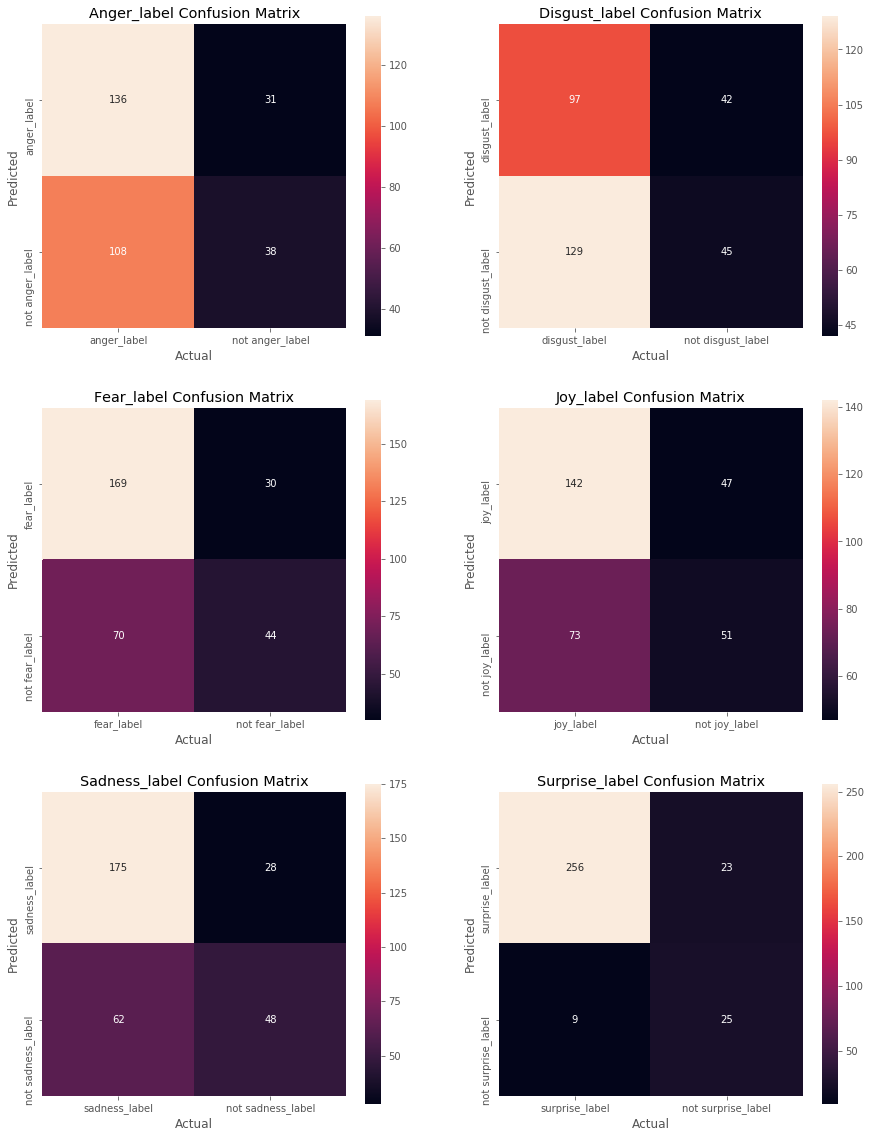

In [66]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], cc_preds_df)



In [67]:
jaccard_score_samples = jaccard_score(y_test, cc_test_preds.toarray(), average='samples')
jaccard_score_weighted = jaccard_score(y_test, cc_test_preds.toarray(), average='weighted')
hamming_loss_score = hamming_loss(y_test, cc_test_preds.toarray())
f1_macro_score = f1_score(y_test, cc_test_preds.toarray(), average='macro')
log_loss_score = log_loss(y_test, cc_test_preds.toarray())
print('jaccard score average:', jaccard_score_samples )
print('jaccard score weighted:', jaccard_score_weighted )
print('hamming loss:', hamming_loss_score)
print('f1 macro:', f1_macro_score)
print('log loss', log_loss_score)

jaccard score average: 0.7005857294994676
jaccard score weighted: 0.6890130324031082
hamming loss: 0.24068157614483493
f1 macro: 0.7979618705554911
log loss 32.83481335877473


## Label Power Emotion Labels

In [69]:
lp = LabelPowerset(svc)

lp.fit(tf_idf_X_train, y_train)
lp_train_preds = lp.predict(tf_idf_X_train)
lp_test_preds = lp.predict(tf_idf_X_test)

In [70]:
LP_preds_df = pd.DataFrame(lp_test_preds.toarray(), columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
LP_preds_df = pd.concat([LP_preds_df, y_reindex], axis=1)


In [71]:
LP_preds_df.head()

,pred_anger_label,pred_disgust_label,pred_fear_label,pred_joy_label,pred_sadness_label,pred_surprise_label,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,0,1,0,1,0,0,1,1,1,1
1,0,1,1,1,1,1,0,0,1,1,1,1
2,0,0,0,1,0,1,0,0,1,0,1,1
3,0,1,1,1,1,1,0,1,1,0,0,1
4,1,0,0,0,0,1,1,1,1,1,1,1


anger_label accuracy: 0.48134328358208955
anger_label precision: 0.75
anger_label recall 0.7413793103448276
anger_label f1 0.7456647398843932


disgust_label accuracy: 0.32677165354330706
disgust_label precision: 0.6148148148148148
disgust_label recall 0.5845070422535211
disgust_label f1 0.5992779783393503


fear_label accuracy: 0.609375
fear_label precision: 0.8342245989304813
fear_label recall 0.7323943661971831
fear_label f1 0.7799999999999999


joy_label accuracy: 0.5141700404858299
joy_label precision: 0.7257142857142858
joy_label recall 0.6580310880829016
joy_label f1 0.6902173913043479


sadness_label accuracy: 0.660377358490566
sadness_label precision: 0.8027522935779816
sadness_label recall 0.7847533632286996
sadness_label f1 0.7936507936507936


surprise_label accuracy: 0.8735177865612648
surprise_label precision: 0.9246861924686193
surprise_label recall 0.7864768683274022
surprise_label f1 0.85




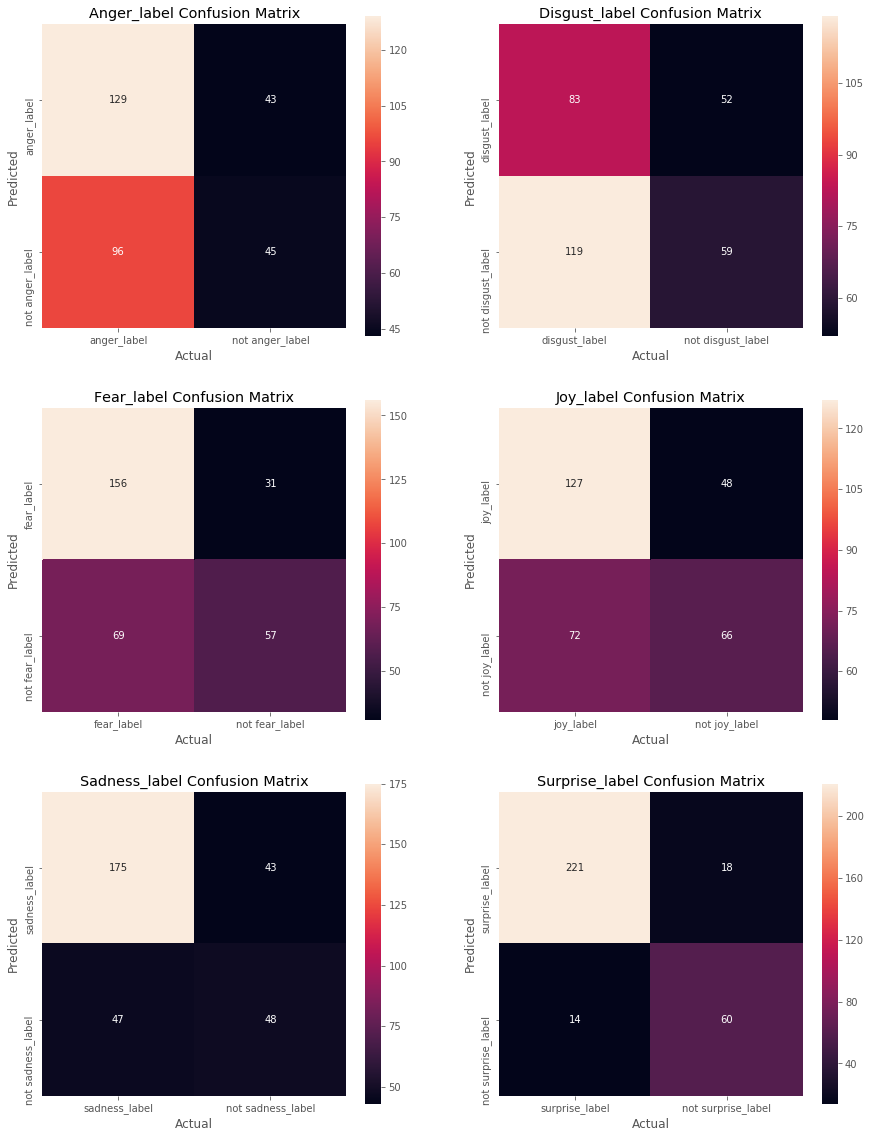

In [74]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], LP_preds_df)


In [73]:
jaccard_score_samples = jaccard_score(y_test, lp_test_preds.toarray(), average='samples')
jaccard_score_weighted = jaccard_score(y_test, lp_test_preds.toarray(), average='weighted')
hamming_loss_score = hamming_loss(y_test, lp_test_preds.toarray())
f1_macro_score = f1_score(y_test, lp_test_preds.toarray(), average='macro')
log_loss_score = log_loss(y_test, lp_test_preds.toarray())
print('jaccard score average:', jaccard_score_samples )
print('jaccard score weighted:', jaccard_score_weighted )
print('hamming loss:', hamming_loss_score)
print('f1 macro:', f1_macro_score)
print('log loss:', log_loss_score)

jaccard score average: 0.6178381256656017
jaccard score weighted: 0.6170328433013436
hamming loss: 0.3035143769968051
f1 macro: 0.743135150529814
log loss: 41.02267860323945


## RNN for Multilabel Classification

In [75]:
# create a set of unique words in the corpus
vocab = set()
for headline in corpus_df['text']:
    for word in headline.split():
        vocab.add(word)

# get vectors from the pretrained vocab and create a dictionary with the words from the set as keys
glove_embeddings = {}
with open('/Users/flatironschool/Desktop/glove/glove.6B.300d.txt', 'rb') as f:
    for i in f:
        key_vec = i.split()
        word = key_vec[0].decode('utf-8')
        if word in vocab:
            glove_embeddings[word] = np.array(key_vec[1:], dtype=np.float32)
            

In [76]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(corpus_df['text']))

# assign a unique number to each word in the corpus and represents texts via these numbers
sequences = tokenizer.texts_to_sequences(corpus_df['text'])

# add zeros to the front of each sequence as necessary to make them all the same length
padded_X = sequence.pad_sequences(sequences, maxlen=15)


In [77]:
# create an array of zeros the size of the vocabulary by the size of the word vectors
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

# fill the array so that the word vectors that fill the array correspond to their sequence numbers
for ind, word in enumerate(tokenizer.word_index.keys()):
    if word in glove_embeddings.keys():
        embedding_matrix[ind + 1, :] = glove_embeddings[word]
        

In [78]:
X_train, X_test, y_train, y_test = train_test_split(padded_X, emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']], test_size=0.25, random_state=1)

# labels multihot encoded
y_train_multihot = y_train.values
y_test_multihot = y_test.values


In [81]:
model = Sequential()

callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)]

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=15, trainable=False))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=rmsprop(lr=.002, decay=.00001),
              metrics=['accuracy', ])


history = model.fit(X_train, 
                    y_train_multihot,
                    epochs=30,
                    batch_size=100,
                    callbacks=callbacks,
                    class_weight=[{0: 3, 1: 1}, {0: 4, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}],
                    validation_data=(X_test, y_test_multihot))

W0724 10:58:25.539686 4401792448 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 10:58:25.545658 4401792448 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 10:58:25.972324 4401792448 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0724 10:58:25.973053 4401792448 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0724 10:58:26.599200 4401792448 deprecation_wrapper.py:119] Fr

ValueError: Unknown metric function:jaccard_score

313/313 [==============================] - 0s 223us/step


[0.5960828566703552, 0.7577209889698333]

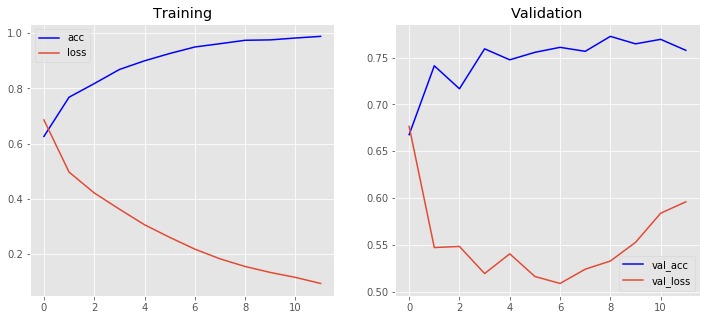

In [46]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(model.history.history['acc'], color='blue', label='acc')
plt.plot(model.history.history['loss'], label='loss')
plt.title("Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(model.history.history['val_acc'], color='blue', label='val_acc')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.title("Validation")
plt.legend()

model.evaluate(X_test, y_test_multihot)


In [47]:
# model.save('RNN_multiclass_emotion.h5')

RNN_preds = model.predict_on_batch(X_test)

RNN_preds_df = pd.DataFrame({"pred_anger":RNN_preds[:,0], "pred_disgust":RNN_preds[:,1], "pred_fear":RNN_preds[:,2], "pred_joy":RNN_preds[:,3], "pred_sadness":RNN_preds[:,4], "pred_surprise":RNN_preds[:,5], "anger":y_test_multihot[:,0], "disgust":y_test_multihot[:,1], "fear": y_test_multihot[:,2], "joy": y_test_multihot[:,3], "sadness": y_test_multihot[:,4], "surprise": y_test_multihot[:,5]})


anger accuracy: 0.4404332129963899
anger precision: 0.7721518987341772
anger recall 0.7721518987341772
anger f1 0.7721518987341772


disgust accuracy: 0.3204225352112676
disgust precision: 0.6363636363636364
disgust recall 0.7583333333333333
disgust f1 0.6920152091254753


fear accuracy: 0.6063829787234043
fear precision: 0.7737556561085973
fear recall 0.8465346534653465
fear f1 0.8085106382978723


joy accuracy: 0.5680933852140078
joy precision: 0.8156424581005587
joy recall 0.7227722772277227
joy f1 0.7664041994750658


sadness accuracy: 0.6123188405797102
sadness precision: 0.8125
sadness recall 0.8203883495145631
sadness f1 0.8164251207729469


surprise accuracy: 0.8767605633802817
surprise precision: 0.9021739130434783
surprise recall 0.89568345323741
surprise f1 0.8989169675090252




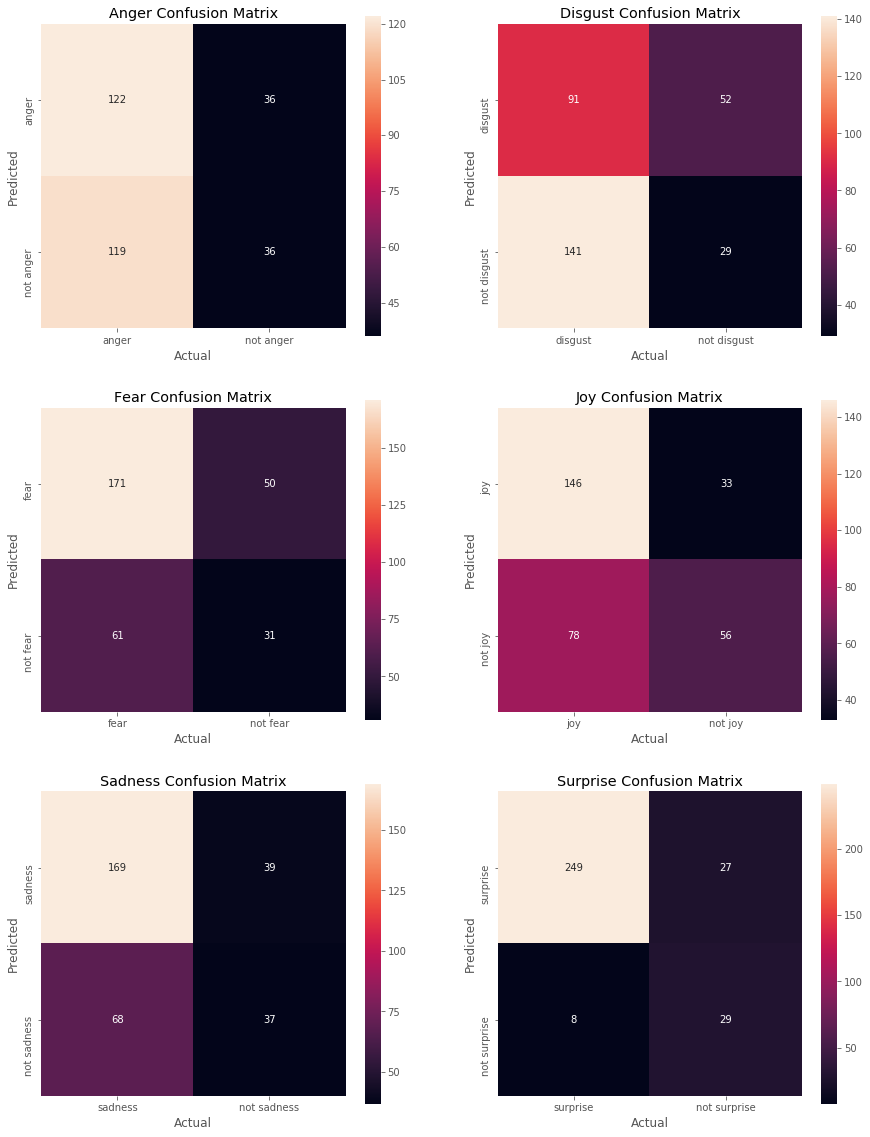

In [48]:
evaluate_multilabel_classification(['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'], RNN_preds_df, RNN=True)

In [52]:
jaccard_score_samples = jaccard_score(y_test, RNN_preds>.5, average='samples')
jaccard_score_weighted = jaccard_score(y_test, RNN_preds>.5, average='weighted')
hamming_loss_score = hamming_loss(y_test, RNN_preds>.5)
f1_macro_score = f1_score(y_test, RNN_preds>.5, average='macro')
log_loss_score = log_loss(y_test, RNN_preds>.5)
print('jaccard score average:', jaccard_score_samples )
print('jaccard score weighted:', jaccard_score_weighted )
print('hamming loss:', hamming_loss_score)
print('f1 macro:', f1_macro_score)
print('log loss:', log_loss_score)

jaccard score average: 0.6919062832800852
jaccard score weighted: 0.6813669245111486
hamming loss: 0.2422790202342918
f1 macro: 0.7924040056524272
log loss: 28.234306754153195
